# K-means Clustering

This notebook will cover both the maths and implementation of the K-means clustering algorithm. Finally, example of the use of the algorithm is shown.

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```
for i in range(num_trials)
    1. Randomly initialize centroids
    for j in range(iterations):
        2. Perform cluster assignment: Assign each data point to the closest centroid
        3. Compute centroid: Compute means based on centroid assignments
    4. Compute cost function (distortion)
    
Pick clustering that gave the lowest cost
```

## Cluster assignment 

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid.

## Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

## Compute cost function (distortion)

The optimization objective of the K-means algorithm is defined as:

$$ J = \frac{1}{m} \sum_{i = 1}^{m} \lvert\rvert x^{(i)} - \mu_{c^{(i)}}  \lvert\rvert^2$$

where $m$ is the total number of data points $x^{(i)}$ and $\mu_{c^{(i)}}$ is the  cluster centroid of cluster to which data point $x^{(i)}$ has been assigned.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.datasets import make_blobs

In [2]:
class KMeans():
    """
    Implementation note:
    
    X : array_like 
        The dataset of size (m x n).
        
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
        
    
    K : int
        The number of clusters.
        
    cluster_ids : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    """
    
    def __init__(self, n_clusters, num_trials=5, max_iter=10):
        self.n_clusters = n_clusters
        self.num_trials = num_trials
        self.max_iter = max_iter
        self.centroids = None
        self.cost_history = list()
        
    def _init_centroids(self, X):
        """ Randomly initialize centroids """
        
        # Randomly reorder the indices of examples
        randidx = np.random.permutation(X.shape[0])
        
        # Take the first K examples as centroids
        self.centroids = X[randidx[:self.n_clusters], :]
        
    def _cluster_assignment(self, X):
        """ Perform cluster assignment """
        
        centroid_ids = np.zeros(X.shape[0], dtype=int)
        
        for i in range(X.shape[0]):
            dist = self._squared_euclidean_distance(X[i,:], self.centroids[:,:])
            centroid_ids[i] = np.argmin(dist)
            
        return centroid_ids
        
    def _compute_centroids(self, X, cluster_ids):
        """ Compute means based on centroid assignments (cluster_ids) """
        
        # Get number of example (m) and features (n)
        m, n = X.shape
        
        # zero initialization
        centroids = np.zeros((self.n_clusters, n))
        
        for i in range(self.n_clusters):
            c = np.where(cluster_ids == i)[0]
            centroids[i, :] = np.sum(X[c,:], axis=0) / len(c)
            
        return centroids
    
    def _cost_function(self, X):
        """ Compute cost function (distortion) """
        
        cost = 0
        for i in range(X.shape[0]):
            dist = self._squared_euclidean_distance(X[i,:], self.centroids[:,:])
            cost += np.min(dist)
        
        return cost / X.shape[0]
    
    
    @staticmethod
    def _squared_euclidean_distance(A, B):
        """ Compute squared euclidean distance """
        
        return np.linalg.norm(A - B, axis=1) ** 2
    
            
    def fit(self, X):
        """ Fit KMeans using training data X (m, n) => (examples, features) """
        
        # Centroids for each trial
        centroids_trials_map = dict()
        
        for trial_num in range(self.num_trials):
            
            # Randomly initialize centroids
            self._init_centroids(X)
        
            for i in range(self.max_iter):
                centroid_ids = self._cluster_assignment(X)
                new_centroids = self._compute_centroids(X, centroid_ids)
            
            
                # stop iteration if centroids didn't change
                if np.all((new_centroids - self.centroids) == 0.):
                    break
                else:
                    self.centroids = new_centroids
                    
            # save cost function value for each trial
            cost = self._cost_function(X)
            self.cost_history.append(cost)
            
            # Save centroids for each trial
            centroids_trials_map[trial_num] = self.centroids
        
        # Assign centroid that minimizes cost function
        best_trial = self.cost_history.index(min(self.cost_history))
        self.centroids = centroids_trials_map[best_trial]
        
        return
    

    
    def predict(self, X):
        """ Predict cluster which each example in X(m,n) belong using the fitted centroids """
        
        if self.centroids is None:
            raise Exception ("Error: Fit KMeans first")
            
        centroid_ids = self._cluster_assignment(X)
        
        return centroid_ids
            

# Example 1: 2D dataset

Let's try the KMeans algorithm on a 2D toy dataset as shown below:

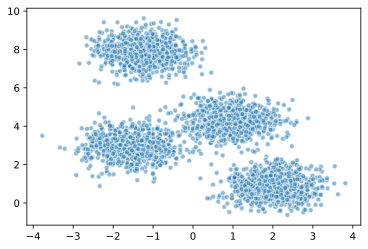

In [3]:
# Make dataset
X, y = make_blobs(n_samples=3000, centers=4, n_features=2, cluster_std=0.6, random_state=0)

# Make plot
plt.scatter(X[:, 0], X[:, 1], s=24, edgecolors='w', alpha=0.5)
plt.show()

## Define and fit KMeans

In [4]:
k_means = KMeans(n_clusters=4, num_trials=5, max_iter=20)
k_means.fit(X)
result = k_means.predict(X)

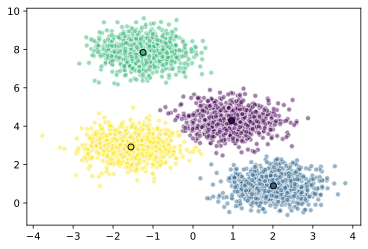

In [5]:
# Make plot
plt.scatter(X[:, 0], X[:, 1], c=result, s=24, edgecolors='w', alpha=0.5)
plt.scatter(k_means.centroids[:, 0], k_means.centroids[:, 1],
            c=np.arange(k_means.n_clusters), edgecolors='k')
plt.show()

# Example 2: 3D dataset

Let's try the KMeans algorithm on a 3D toy dataset as shown below:

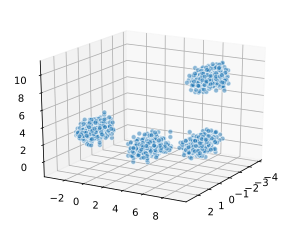

In [6]:
# Make dataset
X, y = make_blobs(n_samples=3000, centers=4, n_features=3, cluster_std=0.5, random_state=0)

# Make plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, elev=20, azim=30)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=24, edgecolors='w', alpha=0.5)
plt.show()

## Define and fit KMeans

In [7]:
k_means = KMeans(n_clusters=4, num_trials=5, max_iter=20)
k_means.fit(X)
result = k_means.predict(X)

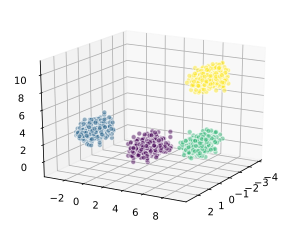

In [8]:
# Make plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, elev=20, azim=30)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=result, s=24, edgecolors='w', alpha=0.5)
ax.scatter(k_means.centroids[:, 0], k_means.centroids[:, 1], k_means.centroids[:, 2],
            c=np.arange(k_means.n_clusters), edgecolors='k')
plt.show()